# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
# from mlagents.envs import UnityEnvironment

import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
environment_path = "Environments/Banana.app"
env = UnityEnvironment(file_name=environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [22]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
    
# print("Score: {}".format(score))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

# Imports

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import math
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


# Set device

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dueling Q Network

In [45]:
class Dueling_QNetwork(nn.Module):
    def __init__(self,state_space,action_space,seed,hidden_dims=(32,32),activation_fc=F.relu):
        super(Dueling_QNetwork,self).__init__()
        self.activation_fc = activation_fc
        self.seed = torch.manual_seed(seed)
        print('hidden_dims',hidden_dims)
        self.input_layer = nn.Linear(state_space,int(hidden_dims[0]))
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.value_output = nn.Linear(hidden_dims[-1],1)
        self.advantage_output = nn.Linear(hidden_dims[-1],action_space)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32) #device = self.device,
            x = x.unsqueeze(0)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        a = self.advantage_output(x)
        v = self.value_output(x)
        v = v.expand_as(a)
        q = v + a - a.mean(1,keepdim=True).expand_as(a)
        return q

# Priority Tree

In [46]:
"""
Priority Tree.
3 tiered tree structure containing
Root node (Object. sum of all lower values)
Intermediate Node (Object. Root as parent, sums a given slice of the priority array)
Priority Array (Array of priorities, length buffer_size)

The number of Intermediate nodes is calculated by the buffer_size / batch_size.

I_episode: current episode of training

Index: is calculated by i_episode % buffer_size. This loops the index after exceeding the buffer_size.

Indices: (List) of memory/priority entries

intermediate_dict: maps index to intermediate node. Since each Intermediate node is responsible 
for a given slice of the priority array, given a particular index, it will return the Intermediate node
'responsible' for that index.

## Functions:

Add:
Calculates the priority of each TD error -> (abs(TD_error)+epsilon)**alpha
Stores the priority in the Priority_array.
Updates the sum_tree with the new priority

Update_Priorities:
Updates the index with the latest priority of that sample. As priorities can change over training
for a particular experience

Sample:
Splits the current priority_array based on the number of entries, by the batch_size.
Returns the indicies of those samples and the priorities.

Propogate:
Propogates the new priority value up through the tree
"""

class PriorityTree(object):
    def __init__(self,buffer_size,batch_size,alpha,epsilon):
        self.alpha = alpha
        self.epsilon = epsilon
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.num_intermediate_nodes = math.ceil(buffer_size / batch_size)
        self.current_intermediate_node = 0
        self.root = Node(None)
        self.intermediate_nodes = [Intermediate(self.root,batch_size*x,batch_size*(x+1)) for x in range(self.num_intermediate_nodes)]
        self.priority_array = np.zeros(buffer_size)
        self.intermediate_dict = {}
        for index,node in enumerate(self.intermediate_nodes):
            for key in range((batch_size*(index+1))-batch_size,batch_size*(index+1)):
                self.intermediate_dict[key] = node
        print('Priority Tree: Batch Size {} Buffer size {} Number of intermediate Nodes {}'.format(batch_size,buffer_size,self.num_intermediate_nodes))
        
    def add(self,TD_error,index):
        priority = (abs(TD_error)+self.epsilon)**self.alpha
        self.priority_array[index] = priority
        # Update sum
        propogate(self.intermediate_dict[index],self.priority_array)
    
    def sample(self,index):
        # Sample one experience uniformly from each slice of the priorities
        if index >= self.buffer_size:
            indicies = [random.sample(list(range(sample*self.num_intermediate_nodes,(sample+1)*self.num_intermediate_nodes)),1)[0] for sample in range(self.batch_size)]
        else:
            interval = int(index / self.batch_size)
            indicies = [random.sample(list(range(sample*interval,(sample+1)*interval)),1)[0] for sample in range(self.batch_size)]
#         print('indicies',indicies)
        priorities = self.priority_array[indicies]
        return priorities,indicies
    
    def update_priorities(self,TD_errors,indicies):
#         print('TD_errors',TD_errors)
#         print('TD_errors shape',TD_errors.shape)
        priorities = (abs(TD_errors)+self.epsilon)**self.alpha
#         print('priorities shape',priorities.shape)
#         print('indicies shape',len(indicies))
#         print('self.priority_array shape',self.priority_array.shape)
        self.priority_array[indicies] = priorities
        # Update sum
        nodes = [self.intermediate_dict[index] for index in indicies] 
        intermediate_nodes = set(nodes)
        [propogate(node,self.priority_array) for node in intermediate_nodes]
    
class Node(object):
    def __init__(self,parent):
        self.parent = parent
        self.children = []
        self.value = 0
            
    def add_child(self,child):
        self.children.append(child)
    
    def set_value(self,value):
        self.value = value
    
    def sum_children(self):
        return sum([child.value for child in self.children])
            
    def __len__(self):
        return len(self.children)

class Intermediate(Node):
    def __init__(self,parent,start,end):
        self.parent = parent
        self.start = start
        self.end = end
        self.value = 0
        parent.add_child(self)
    
    def sum_leafs(self,arr):
        return np.sum(arr[self.start:self.end])

def propogate(node,arr):
    if node.parent != None:
        node.value = node.sum_leafs(arr)
        propogate(node.parent,arr)
    else:
        node.value = node.sum_children()

# Priority Replay Buffer

In [47]:
"""
Priority Buffer HyperParameters
alpha(priority or w) dictates how biased the sampling should be towards the TD error. 0 < a < 1
beta(IS) informs the importance of the sample update

The paper uses a sum tree to calculate the priority sum in O(log n) time. As such, i've implemented my own version
of the sum_tree which i call priority tree.

We're increasing beta(IS) from 0.5 to 1 over time
alpha(priority) we're holding constant at 0.5
"""

class PriorityReplayBuffer(object):
    def __init__(self,action_size,buffer_size,batch_size,seed,alpha=0.5,beta=0.5,beta_end=1,beta_duration=1e+5,epsilon=7e-5):
        
        self.seed = random.seed(seed)
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        self.beta_end = beta_end
        self.beta_duration = beta_duration
        self.beta_increment = (beta_end - beta) / beta_duration
        self.max_w = 0
        self.epsilon = epsilon
        self.TD_sum = 0

        self.experience = namedtuple('experience',field_names=['state','action','reward','next_state','done','i_episode'])
        self.sum_tree = PriorityTree(buffer_size,batch_size,alpha,epsilon)
        self.memory = {}
    
    def add(self,state,action,reward,next_state,done,TD_error,i_episode):
        e = self.experience(state,action,reward,next_state,done,i_episode)
        index = i_episode % self.buffer_size
        # add memory to memory and add corresponding priority to the priority tree
        self.memory[index] = e
        self.sum_tree.add(TD_error,index)

    def sample(self,index):
        # We times the error by these weights for the updates
        # Super inefficient to sum everytime. We could implement the tree sum structure. 
        # Or we could sum once on the first sample and then keep track of what we add and lose from the buffer.
        # priority^a over the sum of the priorities^a = likelyhood of the given choice
        # Anneal beta
        self.update_beta()
        # Get the samples and indicies
        priorities,indicies = self.sum_tree.sample(index)
        # Normalize with the sum
        norm_priorities = priorities / self.sum_tree.root.value
        samples = [self.memory[index] for index in indicies]
#         samples = list(operator.itemgetter(*self.memory)(indicies))
#         samples = self.memory[indicies]
        # Importance weights
#         print('self.beta',self.beta)
#         print('self.beta',self.buffer_size)
        importances = [(priority * self.buffer_size)**-self.beta for priority in norm_priorities]
        self.max_w = max(self.max_w,max(importances))
        # Normalize importance weights
#         print('importances',importances)
#         print('self.max_w',self.max_w)
        norm_importances = [importance / self.max_w for importance in importances]
#         print('norm_importances',norm_importances)
        states = torch.from_numpy(np.vstack([e.state for e in samples if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in samples if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in samples if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in samples if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in samples if e is not None])).float().to(device)
        
        if index % 4900 == 0:
            print('beta',self.beta)
            print('self.max_w',self.max_w)
            print('len mem',len(self.memory))
            print('tree sum',self.sum_tree.root.value)
        
        return (states,actions,rewards,next_states,dones),indicies,norm_importances

    def update_beta(self):
#         print('update_beta')
#         print('self.beta_end',self.beta_end)
#         print('self.beta_increment',self.beta_increment)
        self.beta += self.beta_increment
        self.beta = min(self.beta,self.beta_end)
    
    def __len__(self):
        return len(self.memory.keys())

# Agent

In [74]:
"""
DQN with Priority Replay, DDQN, and Dueling DQN.
"""
class Priority_DQN(object):
    def __init__(self,state_space,action_space,seed,update_every,batch_size,buffer_size,min_buffer_size,learning_rate,GAMMA,tau,clip_norm,alpha):
        self.action_space = action_space
        self.state_space = state_space
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.min_buffer_size = min_buffer_size
        self.learning_rate = learning_rate
        self.update_every = update_every
        self.GAMMA = GAMMA
        self.alpha = alpha
        self.tau = tau
        self.clip_norm = clip_norm
        
        self.qnetwork_local = Dueling_QNetwork(state_space,action_space,seed)
        self.qnetwork_target = Dueling_QNetwork(state_space,action_space,seed)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(),lr=learning_rate)
        # Initialize replaybuffer
        self.memory = PriorityReplayBuffer(action_space,buffer_size,batch_size,seed,alpha)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self,state,action,reward,next_state,done,index):
        # Calculate TD error
        # Target
        current_network_action = self.qnetwork_local(next_state).max(1)[1]
        # initial state comes in as (1,4), squeeze to get (4)
        target = reward + self.GAMMA*(self.qnetwork_target(next_state).squeeze(0)[current_network_action])
        # Local. same rational for squeezing
        local = self.qnetwork_local(state).squeeze(0)[action]
        TD_error = reward + target - local
        # Save the experience
        self.memory.add(state,action,reward,next_state,done,TD_error,index)
        
        # learn from the experience
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.min_buffer_size:
                experiences,indicies,weights = self.memory.sample(index)
                self.learn(experiences,indicies,weights)
        
    def act(self,state,eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_space))
        
    def learn(self,experiences,indicies,weights):
        
        states,actions,rewards,next_states,dones = experiences
        # Local max action
        local_next_state_actions = self.qnetwork_local(next_states).max(1)[1].unsqueeze(1)
        # Target
        target_values = self.qnetwork_target(next_states).detach()
        max_target = target_values.gather(1,local_next_state_actions)
#         print('max_target size',max_target.size())
        max_target *= (1-dones) 
        targets = rewards + (self.GAMMA*max_target)
#         print('targets',targets.size())
#         targets = rewards + self.GAMMA*(target_values.gather(1,local_next_state_actions))
        # Local
        local = self.qnetwork_local(states).gather(1,actions)
        TD_error = local - targets
        loss = ((torch.tensor(weights) * TD_error)**2*0.5).mean()
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(),self.clip_norm)
        self.optimizer.step()
        # Update the priorities
        TD_errors = np.abs(TD_error.squeeze(1).detach().cpu().numpy())
        self.memory.sum_tree.update_priorities(TD_errors,indicies)
        self.update_target()

    # def update_target(self,tau):
    #     for local_param,target_param in zip(self.qnetwork_local.parameters(),self.qnetwork_target.parameters()):
    #         target_param.data.copy_(local_param.data)
    
    def reset_memory(self):
        self.memory = PriorityReplayBuffer(self.action_space,self.buffer_size,self.batch_size,self.seed,self.alpha)
        
    # Polyak averaging  
    def update_target(self):
        for local_param,target_param in zip(self.qnetwork_local.parameters(),self.qnetwork_target.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1-self.tau)*target_param.data)
#         self.qnetwork_local.parameters() = TAU*self.qnetwork_local.parameters() + (1-TAU)*self.qnetwork_target.parameters()

# Train

In [64]:
import torch
import numpy as np
from collections import deque

def train(agent,env,brain_name,checkpoint_path,n_episodes=1800, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        Instead of updating target every (int) steps, using Polyak updating of .1 to gradually merge the networks
    """
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    index = 0
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state,action,reward,next_state,done,index)
            state = next_state
            score += reward
            index += 1
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps*eps_decay,eps_end)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_path)
            break
    return scores

# Initialize Hyperparameters 

In [81]:
BUFFER_SIZE = 10000
MIN_BUFFER_SIZE = 200
BATCH_SIZE = 50
ALPHA = 0.6 # 0.7 or 0.6
START_BETA = 0.5 # from 0.5-1
END_BETA = 1
LR = 0.00025
EPSILON = 1
MIN_EPSILON = 0.01
GAMMA = 0.99
TAU = 0.01
UPDATE_EVERY = 4
CLIP_NORM = 10
checkpoint_path = 'Vector_banana/vector_checkpoint.pth'

# Train the Agent

In [66]:
nA = brain.vector_action_space_size
nS = env_info.vector_observations.shape[1]
print('Observation Space {}, Action Space {}'.format(nS,nA))
seed = 11
agent = Priority_DQN(nS,nA,seed,UPDATE_EVERY,BATCH_SIZE,BUFFER_SIZE,MIN_BUFFER_SIZE,LR,GAMMA,TAU,CLIP_NORM,ALPHA)

scores = train(agent,env,brain_name,checkpoint_path)

Observation Space 37, Action Space 4
hidden_dims (32, 32)
hidden_dims (32, 32)
Priority Tree: Batch Size 50 Buffer size 10000 Number of intermediate Nodes 200
Episode 100	Average Score: 1.25
Episode 200	Average Score: 4.55
Episode 300	Average Score: 7.73
Episode 400	Average Score: 9.42
Episode 500	Average Score: 11.68
Episode 600	Average Score: 12.11
Episode 632	Average Score: 13.00
Environment solved in 632 episodes!	Average Score: 13.00


# Plot the scores

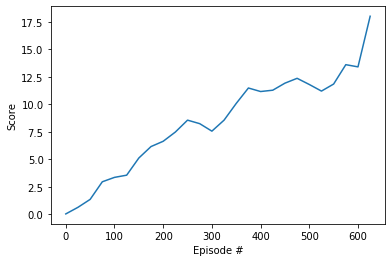

In [68]:
import math
# Rolling mean plot
interval = 25
rolling_mean = [np.mean(scores[(slice_*interval):(slice_+1)*interval]) for slice_ in range(math.ceil(len(scores)/interval))]
x_axis = np.arange(len(rolling_mean)) * interval
plt.plot(x_axis, rolling_mean)
plt.ylabel('Score')
plt.xlabel('Episode #')
# plt.show()
plt.savefig('vector_banana_scores.png',bbox_inches='tight')

# Visualize Agent in the Environment

In [83]:

# try:
#     # load the weights from file
#     agent.qnetwork_local.load_state_dict(torch.load(checkpoint_path))
#     agent.reset_memory()
# except:  
#     # Else reinstantiate the environment and other variablescheckpoint_path = 'vector_checkpoint.pth'
#     nA = brain.vector_action_space_size
#     nS = env_info.vector_observations.shape[1]
#     print('Observation Space {}, Action Space {}'.format(nS,nA))
#     seed = 11
#     agent = Priority_DQN(nS,nA,seed,UPDATE_EVERY,BATCH_SIZE,BUFFER_SIZE,MIN_BUFFER_SIZE,LR,GAMMA,TAU,CLIP_NORM,ALPHA)
#     agent.qnetwork_local.load_state_dict(torch.load(checkpoint_path))
    
# n_episodes = 1
# max_t = 200
# for i in range(1):
#     index = 0
#     for i_episode in range(1,n_episodes+1):
#         env_info = env.reset(train_mode=True)[brain_name]
#         state = env_info.vector_observations[0]
#         score = 0
# #         img = plt.imshow(np.squeeze(env_info.visual_observations[0]))
#         for t in range(max_t):
#             action = agent.act(state,0)
#             env_info = env.step(action)[brain_name]        # send the action to the environment
#             next_state = env_info.vector_observations[0]   # get the next state
#             reward = env_info.rewards[0]                   # get the reward
#             done = env_info.local_done[0]                  # see if episode has finished
#             agent.step(state,action,reward,next_state,done,index)
#             state = next_state
#             index += 1
#             score += reward
#             # save the image
            
# #             img.set_data(np.squeeze(env_info.visual_observations[0])) 
# #             plt.savefig('banana_'+ str(index)+'.png',bbox_inches='tight')
#             if done:
#                 break
#         print(score)
#         if done:
#             break 
            
# env.close()

Priority Tree: Batch Size 50 Buffer size 10000 Number of intermediate Nodes 200


UnityEnvironmentException: No Unity environment is loaded.

# Make a GIF from stored sequence of images

In [ ]:
# import os
# import imageio
# # Make gif from images
# path = '/Users/morgan/RL_gif_images'
# images = []
# filenames = ['test' + str(i) + '.png' for i in range(500)]
# for filename in filenames:
#     images.append(imageio.imread(path +'/'+ filename))
# imageio.mimsave('Navigation.gif', images)